In [2]:
%load_ext autoreload
%autoreload 2

In [49]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# text summarization

In [50]:
df = pd.read_json(open("/home/bobchen/data/text_summarization_result.txt", "r", encoding="utf8"), lines=True)

In [51]:
# nested dict to dataframe
show_wp = ["No Watermark", "$\delta$-reweight", "$\gamma$-reweight"]
john_wps_set = set()


def map_wp_str(wp_str):
    if "Delta" in wp_str:
        return show_wp[1]
    elif "Gamma" in wp_str:
        return show_wp[2]
    elif "John" in wp_str:
        import re
        delta = re.findall(r"delta=(\d+\.?\d*)", wp_str)[0]
        n = "Soft" + f"($\delta$={delta})"
        john_wps_set.add(n)
        return n
    if wp_str == "None":
        return show_wp[0]
    else:
        raise ValueError("Unknown watermark: {}".format(wp_str))

df = df.assign(wp_str=df["watermark_processor"].apply(map_wp_str))
john_wps = sorted(list(john_wps_set))
df.head()

,rouge1,rouge2,rougeL,id,watermark_processor,bertscore.precision,bertscore.recall,bertscore.f1,wp_str
0,0.486486,0.166667,0.297297,000571afe702684d90c1d222ce70b1e1375c1016,WatermarkLogitsProcessor(b'ke\xa6\xa4\x8b\x81H...,0.416267,0.432158,0.425034,$\delta$-reweight
1,0.452174,0.176991,0.313043,000642916e3a6c33411c617cf2f3c134a206fba8,WatermarkLogitsProcessor(b'ke\xa6\xa4\x8b\x81H...,0.352131,0.342983,0.348511,$\delta$-reweight
2,0.278689,0.116667,0.180328,00110802bc6eae0e8e4d3d22e27f458f41be2b22,WatermarkLogitsProcessor(b'ke\xa6\xa4\x8b\x81H...,0.338624,0.349380,0.344958,$\delta$-reweight
3,0.525000,0.410256,0.500000,00119229166ae09a6ef25c0e10b101ef9eb9cca3,WatermarkLogitsProcessor(b'ke\xa6\xa4\x8b\x81H...,0.450495,0.572208,0.510328,$\delta$-reweight
4,0.275229,0.018692,0.128440,0013aa16650fbcfbe6edb16ac614ad174cb5d1cf,WatermarkLogitsProcessor(b'ke\xa6\xa4\x8b\x81H...,0.273203,0.292371,0.283800,$\delta$-reweight


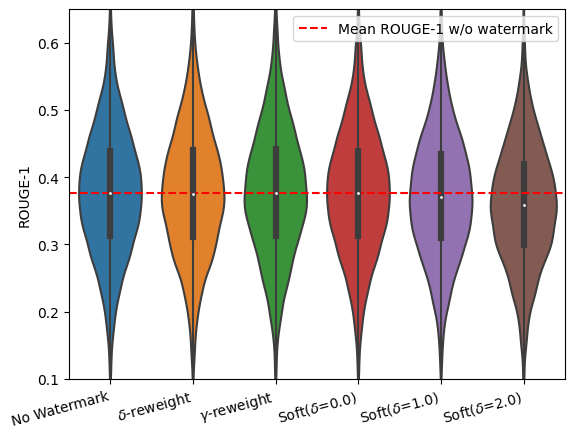

In [54]:
import seaborn as sns

sns.violinplot(
    data=df, x="wp_str", y="rouge1", order=show_wp + john_wps
)
plt.ylabel("ROUGE-1")
plt.xlabel("")
plt.axhline(df[df.wp_str == "No Watermark"].rouge1.mean(), color="red", linestyle="--", label="Mean ROUGE-1 w/o watermark")
plt.xticks(rotation=15,  ha='right')
plt.ylim(0.1, 0.65)
plt.legend()
# plt.show()
plt.savefig("Violin_TS.pdf", format='pdf')

In [55]:
sdf=df.melt(
    id_vars=["wp_str"],
    value_vars=[c for c in df.columns if df[c].dtype == np.float64],
    var_name="score",
    value_name="value",
)
sdf = sdf.groupby(["wp_str", "score"]).agg(["mean", "std", "count"])
sdf = (
    sdf["value"]
    .apply(
        lambda x: "{:.4f}±{:.4f}".format(x["mean"], x["std"] / np.sqrt(x["count"])),
        axis=1,
    )
    .unstack()
)
sdf = sdf.loc[show_wp + john_wps]
sdf

score,bertscore.f1,bertscore.precision,bertscore.recall,rouge1,rouge2,rougeL
wp_str,,,,,,
No Watermark,0.3170±0.0008,0.3057±0.0009,0.3285±0.0009,0.3766±0.0009,0.1322±0.0007,0.2378±0.0007
$\delta$-reweight,0.3170±0.0008,0.3057±0.0009,0.3286±0.0010,0.3770±0.0009,0.1326±0.0007,0.2383±0.0007
$\gamma$-reweight,0.3177±0.0008,0.3062±0.0009,0.3294±0.0010,0.3779±0.0009,0.1333±0.0008,0.2382±0.0007
Soft($\delta$=0.0),0.3170±0.0008,0.3057±0.0009,0.3285±0.0009,0.3766±0.0009,0.1322±0.0007,0.2378±0.0007
Soft($\delta$=1.0),0.3125±0.0008,0.2957±0.0009,0.3295±0.0009,0.3719±0.0009,0.1271±0.0007,0.2325±0.0007
Soft($\delta$=2.0),0.2987±0.0007,0.2750±0.0008,0.3229±0.0009,0.3597±0.0008,0.1153±0.0006,0.2206±0.0006


# translation

In [56]:
dire = '/home/xiaoniu/workspace/machinelearning/2023.04.25.watermark/main_repo/data'
df = pd.read_json(open(f"{dire}/machine_translation_result.txt", "r", encoding="utf8"), lines=True)

In [57]:
df = df.assign(wp_str=df["watermark_processor"].apply(map_wp_str))
df.head()

,id,watermark_processor,bertscore.precision,bertscore.recall,bertscore.f1,wp_str
0,046d337cc27945f44ed98960cb02138763e18c7f,WatermarkLogitsProcessor(b'ke\xa6\xa4\x8b\x81H...,0.107592,0.119766,0.114969,$\delta$-reweight
1,046d8b9c8c0fc383a8b158d974a84845ab126e97,WatermarkLogitsProcessor(b'ke\xa6\xa4\x8b\x81H...,0.473250,0.523102,0.498625,$\delta$-reweight
2,046ed99bc89832c8b5c25bfe70e524d70fac0b78,WatermarkLogitsProcessor(b'ke\xa6\xa4\x8b\x81H...,0.417474,0.452439,0.435644,$\delta$-reweight
3,046f0822ef861da6cc18cca98e19850552f38f65,WatermarkLogitsProcessor(b'ke\xa6\xa4\x8b\x81H...,0.023834,0.054939,0.040662,$\delta$-reweight
4,0471a5c20ce16e7cf8527c2a7e7bf3ff7388b503,WatermarkLogitsProcessor(b'ke\xa6\xa4\x8b\x81H...,0.281730,0.253207,0.268442,$\delta$-reweight


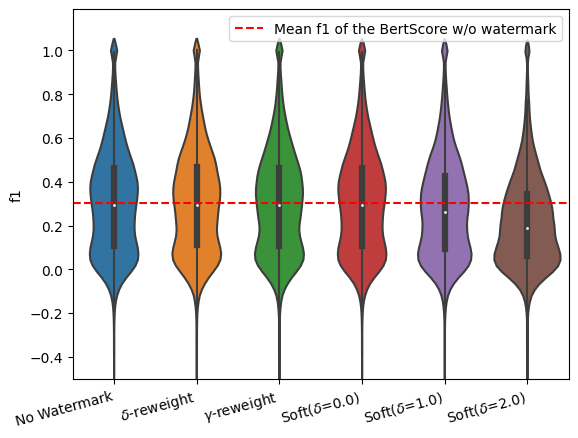

In [59]:
import seaborn as sns

sns.violinplot(
    data=df, x="wp_str", y="bertscore.f1", order=show_wp + john_wps
)
plt.axhline(df[df.wp_str == "No Watermark"]['bertscore.f1'].mean(), color="red", linestyle="--", label="Mean f1 of the BertScore w/o watermark")
plt.ylabel("f1")
plt.xlabel("")
plt.xticks(rotation=15,  ha='right')
plt.legend()
plt.ylim(-0.5, None)

plt.savefig('violin_mt.pdf')

In [40]:
sdf=df.melt(
    id_vars=["wp_str"],
    value_vars=[c for c in df.columns if df[c].dtype == np.float64],
    var_name="score",
    value_name="value",
)
ndf = pd.read_json(open("/home/bobchen/data/machine_translation_bleu.txt", "r", encoding="utf8"), lines=True)
ndf = ndf.assign(wp_str=ndf["watermark_processor"].apply(map_wp_str))
ndf=ndf.melt(
    id_vars=["wp_str"],
    value_vars=[c for c in ndf.columns if ndf[c].dtype == np.float64],
    var_name="score",
    value_name="value",
)
sdf = pd.concat([sdf, ndf])
sdf = sdf.groupby(["wp_str", "score"]).agg(["mean", "std", "count"])
sdf1 = sdf.copy(deep=True)
sdf2 = sdf.copy(deep=True)

In [41]:
sdf1 = (
    sdf1["value"]
    .apply(
        lambda x: "{:.4f}±{:.4f}".format(x["mean"], x["std"] / np.sqrt(x["count"])),
        axis=1,
    )
    .unstack()
)

sdf2 = (
    sdf2["value"]
    .apply(
        lambda x: "{:.4f}±{:.4f}".format(x["mean"], x["std"]),
        axis=1,
    )
    .unstack()
)

sdf1 = sdf1.loc[show_wp + john_wps]
sdf2 = sdf2.loc[show_wp + john_wps]

sdf1['bleu'] = sdf2['bleu']
sdf1


score,bertscore.f1,bertscore.precision,bertscore.recall,bleu
wp_str,,,,
No Watermark,0.3045±0.0010,0.2910±0.0010,0.3189±0.0010,9.3972±0.4218
$\delta$-reweight,0.3068±0.0010,0.2938±0.0010,0.3207±0.0010,9.3005±0.3393
$\gamma$-reweight,0.3042±0.0010,0.2912±0.0010,0.3183±0.0010,9.3924±0.4292
Soft Red List($\delta$=0.0),0.3045±0.0010,0.2910±0.0010,0.3189±0.0010,9.3972±0.4218
Soft Red List($\delta$=1.0),0.2791±0.0010,0.2619±0.0010,0.2973±0.0010,8.2078±0.3551
Soft Red List($\delta$=2.0),0.2200±0.0009,0.1951±0.0009,0.2463±0.0009,5.5241±0.2696
